In [1]:
# Imports
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import factorial
import peakutils
import numpy as np
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

import qcodes.instrument.parameter as parameter

loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

<IPython.core.display.Javascript object>

In [2]:
# Load instruments
import qcodes.instrument_drivers.lecroy.ArbStudio1104 as ArbStudio_driver
import qcodes.instrument_drivers.spincore.PulseBlasterESRPRO as PulseBlaster_driver
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver
from meta_instruments import Analysis

def try_close_instruments(instruments=['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass
        
def plot_traces(traces, traces_AWG=None):
    plt.figure()
    plt.pcolormesh(range(traces.shape[1]), 
                 range(traces.shape[0]+1), traces)
    if traces_AWG is not None:
        trace_AWG = traces_AWG[:1]
        trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
        trace_AWG -= np.min(trace_AWG)
        plt.pcolormesh(range(traces.shape[1]), 
                       np.array([0,1])+traces.shape[0], trace_AWG)
    plt.xlim([0,traces.shape[1]])
    plt.ylim([0,traces.shape[0]+1])
    plt.colorbar()

    fig, axes = plt.subplots(len(traces), sharex=True)
    for k, trace in enumerate(traces):
        axes[k].plot(trace)
        axes[k].plot(trace > 0.5)
        if traces_AWG is not None:
            trace_AWG = traces_AWG[k]
            trace_AWG /= (np.max(trace_AWG)-np.min(trace_AWG))
            trace_AWG -= np.min(trace_AWG)
            axes[k].plot(trace_AWG)
        else:
            axes[k].plot([1]*load_pts+[0.5]*read_pts+[0]*empty_pts)
    
# dummy_param = parameter.ManualParameter(name="dummy", initial_value=42)

for instrument_name in ['ArbStudio', 'PulseBlaster', 'SIM900','ATS', 'ATS_controller']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))
try_close_instruments('Analysis')
reload(Analysis)

dll_path = os.path.join(os.getcwd(),'lecroy_driver\\Library\\ArbStudioSDK.dll')
ArbStudio = ArbStudio_driver.ArbStudio1104('ArbStudio', dll_path, server_name=None)

PulseBlaster = PulseBlaster_driver.PulseBlaster('PulseBlaster', api_path='spinapi.py', server_name='PB_server')

SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, NOTUSED, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Basic_AcquisitionController(name='ATS_controller', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

readout_analysis = Analysis.BasicAnalysis(name='basic_analysis', server_name=None)

In [3]:
def configure_PulseBlaster(PulseBlaster, durations, marker_cycles=100, sampling_rate=500):
    # Factor of 2 needed because apparently the core clock is not the same as the sampling rate
    ms = 2 * sampling_rate * 1e3

    PulseBlaster.detect_boards()
    PulseBlaster.select_board(0)
    PulseBlaster.core_clock(sampling_rate)

    PulseBlaster.start_programming()
    
    pulse = 'empty'
    PulseBlaster.send_instruction(0,'continue',0, marker_cycles)
    start = PulseBlaster.send_instruction(0, 'continue', 0, durations[pulse]*ms - marker_cycles)
    
    pulse = 'load'
    PulseBlaster.send_instruction(1,'continue',0, marker_cycles)
    PulseBlaster.send_instruction(0, 'continue', start, durations[pulse]*ms - marker_cycles)
    
    pulse = 'read'
    PulseBlaster.send_instruction(1,'continue',0, marker_cycles)
    PulseBlaster.send_instruction(0, 'continue', 0, durations[pulse]*ms - marker_cycles)
    
    pulse = 'final_delay'
    if durations[pulse] > 0:
        PulseBlaster.send_instruction(0, 'continue', 0, durations[pulse]*ms)
    PulseBlaster.send_instruction(1,'branch',start, marker_cycles)
    
    PulseBlaster.stop_programming()
    
def configure_ArbStudio(ArbStudio, voltages, channel_factors, marker_cycles=100):
    stages = ['empty', 'load', 'read']
    for ch in [1,2,3,4]:
        eval('ArbStudio.ch{}_clear_waveforms()'.format(ch))
    for ch in [1, 2, 3]:
        eval("ArbStudio.ch{}_trigger_source('fp_trigger_in')".format(ch))
        eval("ArbStudio.ch{}_trigger_mode('stepped')".format(ch))
        eval('ArbStudio.ch{}_clear_waveforms()'.format(ch))
        waveforms = channel_factors[ch-1] * np.array([[voltages[stage]]*4 for stage in stages])
        for waveform in waveforms:
            eval('ArbStudio.ch{}_add_waveform(waveform)'.format(ch))

        eval('ArbStudio.ch{}_sequence([0, 1, 2])'.format(ch))
    waveforms = ArbStudio.load_waveforms(channels=[1,2,3])
    sequences = ArbStudio.load_sequence(channels=[1,2,3])
    return waveforms, sequences

def configure_ATS(ATS, trigger_level=100, trigger_slope='TRIG_SLOPE_NEGATIVE'):
    ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=trigger_level,
           trigger_slope1=trigger_slope,
           external_trigger_coupling='DC',
           trigger_operation='TRIG_ENGINE_OP_J',
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')
    
def configure_ATS_controller(ATS_controller, durations, acquisition_stages=['empty', 'load', 'read'],
                             samples=200, average_mode='none'):
    read_length = sum([durations[stage] for stage in acquisition_stages])
    sample_rate = ATS_controller._get_alazar_parameter('sample_rate')
    samples_per_record = int(16 * round(float(sample_rate*read_length*1e-3)/16))
    
    total_duration = sum(durations.values())*1e-3
    buffer_timeout = max(5000, 1.5*total_duration)
    
    ATS_controller.average_mode(average_mode)
    ATS_controller.update_acquisition_kwargs(samples_per_record=samples_per_record,
                                             records_per_buffer=1,
                                             buffers_per_acquisition=samples,
                                             buffer_timeout=buffer_timeout,
                                             channel_selection='AC')

# Tuning

Wall time: 233 ms


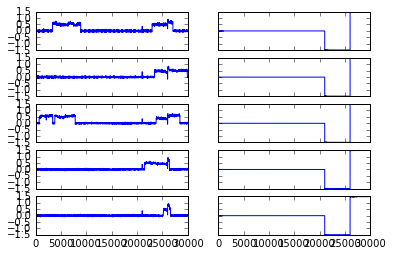

In [4]:


compensation_factor = -1.5
channel_factors = [1, compensation_factor, 1]
voltages = {'empty': -1.5, 'load': 1.5, 'read': 0}
durations = {'empty': 5, 'load': 5, 'read': 20, 'final_delay': 1}

configure_PulseBlaster(PulseBlaster, durations)
configure_ArbStudio(ArbStudio, voltages, channel_factors)

# trigger level <128 is below 0V, >128 is above 0V
configure_ATS(ATS, trigger_level=140, trigger_slope='TRIG_SLOPE_NEGATIVE')
configure_ATS_controller(ATS_controller, durations, samples=5, 
                         acquisition_stages=['empty','load','read'])
ArbStudio.stop()
ArbStudio.run(channels=[1,2,3])
sleep(.1)

PulseBlaster.start()
%time records = ATS_controller.acquisition()
ArbStudio.stop()
PulseBlaster.stop()


fig, axes = plt.subplots(len(records[0]), len(records),sharex=True, sharey=True)
for k, records_ch in enumerate(records):
    for kk, record in enumerate(records_ch):
        axes[kk, k].plot(record)



2 peaks found
0.232902018229


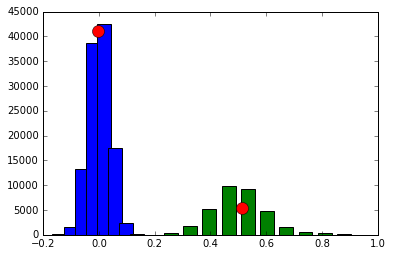

In [5]:
_, _, threshold_voltage=readout_analysis.find_high_low(records[0], plot=True)

print(threshold_voltage)

# Readout

Wall time: 440 ms


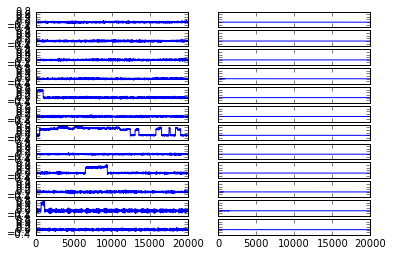

In [102]:

compensation_factor = -1.5
channel_factors = [1, compensation_factor, 1]
voltages = {'empty': -1.5, 'load': 1.5, 'read': 0}
durations = {'empty': 5, 'load': 5, 'read': 20, 'final_delay': 1}

configure_PulseBlaster(PulseBlaster, durations)
configure_ArbStudio(ArbStudio, voltages, channel_factors)

# trigger level <128 is below 0V, >128 is above 0V
configure_ATS(ATS, trigger_level=140, trigger_slope='TRIG_SLOPE_NEGATIVE')
configure_ATS_controller(ATS_controller, durations, samples=12, 
                         acquisition_stages=['read'])

ArbStudio.stop()
ArbStudio.run(channels=[1,2,3])
sleep(.1)

PulseBlaster.start()

%time records = ATS_controller.acquisition()
ArbStudio.stop()
PulseBlaster.stop()


fig, axes = plt.subplots(len(records[0]), len(records),sharex=True, sharey=True)
for k, records_ch in enumerate(records):
    for kk, record in enumerate(records_ch):
         axes[kk, k].plot(record)

0.2
[False, False, False, False, True, False, True, False, True, False, True, False]
0.333333333333


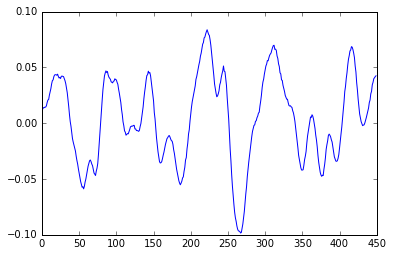

In [135]:


plt.plot(records[0][9][50:500])

reload(Analysis)
print(threshold_voltage)
threshold_voltage=0.2

up=readout_analysis.find_up_proportion(records[0][:,100:], threshold_voltage, return_mean=False)

print(up)
print(sum(up) / len(up))


In [29]:
from scipy import signal
filter=signal.savgol_filter

Wall time: 14 ms
Wall time: 1e+03 µs
99


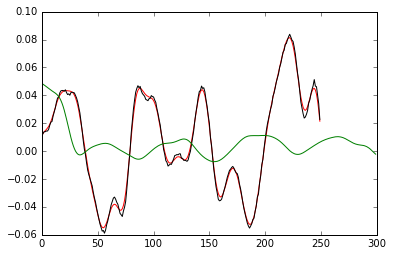

In [137]:

%time testtraces=[filter(trace,window_length=21,polyorder=2) for trace in records[0]]
plt.plot(testtraces[9][50:300], color='r')
plt.plot(records[0][9][50:300], color='k')
%time testtrace2=np.convolve(records[0][9], np.ones(100)/100, mode='valid')
diff=-len(testtrace2)+len(records[0][9])
print(diff)
plt.plot(testtrace2[50-round(diff/2):300], color='g')

 smoothtrace=filter(testtrace,19,4)
print(smoothtrace)

AttributeError: 'numpy.ndarray' object has no attribute 'pd'

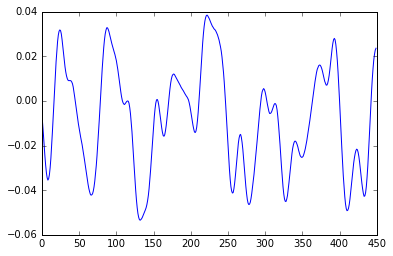